In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:

df = pd.read_csv('Umich_sentiment_analysis_randomized.txt', sep='\t',
                 names=['sentiment', 'document'])

df.head(10)


,sentiment,document
0,0,"Not because I hate Harry Potter, but because I..."
1,0,"Is it just me, or does Harry Potter suck?..."
2,1,"Brokeback Mountain had a beautiful score, and ..."
3,1,i love being a sentry for mission impossible a...
4,0,Harry Potter dragged Draco Malfoy ’ s trousers...
5,1,"Anyway, thats why I love "" Brokeback Mountain."
6,0,These Harry Potter movies really suck.
7,1,the last stand and Mission Impossible 3 both w...
8,1,I love Brokeback Mountain....
9,1,I love Harry Potter.


In [0]:
length = len(df)  # length of the datframe
pos_count = len(df[df['sentiment'] == 1])  # positive_sentiment count
neg_count = len(df[df['sentiment'] == 0])  # negative_sentiment count
print (
    'length=',
    length,
    '\npos_count',
    pos_count,
    '\nneg_count',
    neg_count,
    )

length= 6725 
pos_count 3804 
neg_count 2921


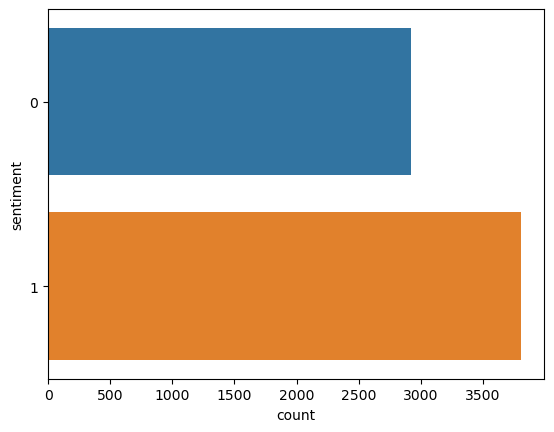

In [0]:

sns.countplot(y="sentiment",data=df)#plotting the data
plt.show()

**sentence_to_words()**:here we first convert the sentence to lowercase. Then we use .split() to split it into different words. We iterate over the letters of the word to pinpoint which are alphabets and which are not. 

**bag_of_words_maker()**: This function takes in the document and the class for each document and converts it into the _bag of words_ format . We folloed the binary multinomial NB , so the repition of words in the document was not noted. We place more weight on the fact whether the word is present or not rather than no of times it appeared. I tried to implement a rudimentary stop_word list to the selected words. This function returns the length of the positive class and the negative sentiment class along with the bag of words in a dataframe form . It lists the number of times each word has been repeated in the positive and negative sentiment class respectively.

**naive_bias_train()**: here we send the document and class series respectively . It calculates the prior probability of each class
{ P(C<sub>neg</sub>),P(C<sub>pos</sub>) } and it claculates the P(w<sub>i</sub>/C) using the formula :

 P(w<sub>i</sub>/C)=count(w<sub>i</sub>,c)+a/x+V*a , where a is the laplace smoothing function, x is the length of the class c and V is the total vocabulary(total length of the bag_of_words)

It returns the prior probability of both classes(in this case positive and negative) and the dataframe containing the likelihood probability of each word.


**naive_bias_predict()**: Now we finally predict the given test case. We loop over the number of documents present in the test dataframe. looping over the total length of bag we find if the words of the given document is present in the bag or not . If True we multiply the likelihood probability for both positive and negative class. Finally we multiply the prior probability of the respective classes to the likelihood and decide for which class the probability is max. Essentially this step:

C<sub>nb</sub>=argmax<sub>c∈C</sub> P(w<sub>i</sub>/c)*P(c)

It returns the list of predicted classes.

In [0]:



def sentence_to_words(sentence):

    l = sentence.lower()  # convert sentence to lowercase
    l = l.split()  # split sentence into individual word
    p = ''
    word_list = []

    for word in l:

        p = ''

        for letter in word:

            if ord(letter) >= 67 and ord(letter) <= 122:
                p = p + letter
        word_list.append(p)

    return word_list  # return the word list of the sentence devoid of special characters and numericals


def naive_bayes_train(X, Y, a=0.000001):
    n_length = len(X)
    n_class_pos = len(Y[Y == 1])
    n_class_neg = len(Y[Y == 0])
    prior_pos = n_class_pos / n_length  # prior probability for  class
    prior_neg = n_class_neg / n_length
    (n, p, bag) = bag_of_words_maker(X, Y)

    pr = {}

    for i in range(len(bag)):
        p_pos = (bag['count_pos'][i] + a) / (p + len(bag) * a)

        p_neg = (bag['count_neg'][i] + a) / (n + len(bag) * a)

        pr[bag['index'][i]] = [p_pos, p_neg]
    pr = pd.DataFrame(pr).T
    pr.columns = ['sent=positive', 'sent=negative']
    pr = pr.reset_index()

    return (prior_pos, prior_neg, pr)


def naive_bayes_predict(
    X,
    pr,
    prior_pos,
    prior_neg,
    ):
    Y = []

    for i in range(len(X)):
        k_pos = 1
        k_neg = 1
        p = sentence_to_words(X[i])

        for k in range(len(pr)):

            for word in p:

                if word == pr['index'][k]:
                    k_pos = k_pos * pr['sent=positive'][k]
                    k_neg = k_neg * pr['sent=negative'][k]

        nb = [prior_neg * k_neg, prior_pos * k_pos]
        Y.append(np.argmax(nb))

    return Y


def bag_of_words_maker(X, Y):

    bag_dict_binary_NB_pos = {}
    bag_dict_binary_NB_neg = {}
    stop_words = [
        'the',
        'da',
        'vinci',
        'is',
        'a',
        'was',
        'it',
        'brokeback',
        'mountain',
        'code',
        'and',
        '',
        'harry',
        'potter',
        'i',
        'am',
        'of',
        'that',
        ]
    for i in range(len(X)):
        p = sentence_to_words(X[i])
        sent = Y[i]
        x_pos = {}
        x_neg = {}

        if sent == 1:
            for word in p:

                if word in x_pos.keys():
                    x_pos[word] = [x_pos[word][0] + 1, x_pos[word][1]]
                else:
                    x_pos[word] = [1, sent]

            for key in x_pos.keys():

                if key in bag_dict_binary_NB_pos.keys():
                    bag_dict_binary_NB_pos[key] = \
                        [bag_dict_binary_NB_pos[key][0] + 1,
                         bag_dict_binary_NB_pos[key][1]]
                else:

                    bag_dict_binary_NB_pos[key] = [1, sent]

        if sent == 0:

            for word in p:
                if word in x_neg.keys():
                    x_neg[word] = [x_neg[word][0] + 1, x_neg[word][1]]
                else:
                    x_neg[word] = [1, sent]
            for key in x_neg.keys():
                if key in bag_dict_binary_NB_neg.keys():
                    bag_dict_binary_NB_neg[key] = \
                        [bag_dict_binary_NB_neg[key][0] + 1,
                         bag_dict_binary_NB_neg[key][1]]
                else:

                    bag_dict_binary_NB_neg[key] = [1, sent]

    # print(bag_dict_multi.keys())

    neg_bag = pd.DataFrame(bag_dict_binary_NB_neg).T
    pos_bag = pd.DataFrame(bag_dict_binary_NB_pos).T

    neg_bag.columns = ['count_neg', 'sentiment_neg']
    pos_bag.columns = ['count_pos', 'sentiment_pos']
    neg_bag = neg_bag.drop(stop_words)
    pos_bag = pos_bag.drop(stop_words)
    neg_bag = neg_bag.reset_index()
    pos_bag = pos_bag.reset_index()
    n = len(neg_bag)
    p = len(pos_bag)
    bag_of_words = pd.merge(neg_bag, pos_bag, on=['index'], how='outer')
    bag_of_words['count_neg'] = bag_of_words['count_neg'].fillna(0)
    bag_of_words['count_pos'] = bag_of_words['count_pos'].fillna(0)
    bag_of_words['sentiment_neg'] = bag_of_words['sentiment_neg'
            ].fillna(0)
    bag_of_words['sentiment_pos'] = bag_of_words['sentiment_pos'
            ].fillna(1)

    return (n, p, bag_of_words)

Heres an example to show how the functions work. Here we send the x and y containing the document and sentiment of the given dataset. bag_of_words_maker returns the length of the positive and negative classes and the binary count for each word in each class. 

In [0]:
x = df['document']
y = df['sentiment']
(n, p, bag_of_words) = bag_of_words_maker(x, y)
print (n, ' ', p)
bag_of_words.head(5)

1460   1373


,index,count_neg,sentiment_neg,count_pos,sentiment_pos
0,not,166.0,0.0,25.0,1.0
1,because,180.0,0.0,327.0,1.0
2,hate,533.0,0.0,12.0,1.0
3,but,141.0,0.0,138.0,1.0
4,type,75.0,0.0,4.0,1.0


This function will return the prior probabilities of each class along with the likeliood probability of each word given a class .

In [0]:
prior_pos,prior_neg,table = naive_bayes_train(x,y)
table.head(5)

,index,sent=positive,sent=negative
0,not,0.018208,0.113698
1,because,0.238164,0.123287
2,hate,0.008740,0.365068
3,but,0.100510,0.096575
4,type,0.002913,0.051370


In [0]:
from sklearn.model_selection import train_test_split

X = df["document"]
Y = df["sentiment"]
x_train, x_test, y_train, y_test = train_test_split(X,Y,)

x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
a,b,bag = naive_bayes_train(x_train,y_train)
y_predicted = naive_bayes_predict(x_test,bag,a,b)
y_predicted

[1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix
print ('Accuracy=', accuracy_score(y_test, np.array(y_predicted)))

(tn, fp, fn, tp) = confusion_matrix(y_test,
                                    np.array(y_predicted)).ravel()

print ('precsion=', tp / (tp + fp))
print ('recall=', tp / (tp + fn))

Accuracy= 0.9720570749108205
precsion= 0.9807073954983923
recall= 0.9692796610169492
